 Dans ce notebook , on a testé trois modélisations après le preprocessing et feature engineering .La premiere méthode était de faire une réduction du nombre de variables à l'aide de xgboost regressor , dans la deuxieme méthode on a utilisé une réduction de dimensions en essayant de trouver les axes principales à l'aide de l'analyse des composantes principales. 
 

In [42]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))



# Exploration et analyse des données 

In [43]:

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Il y a quelques maisons avec la variable GrvLivArea supérieure à 4000 qu'on peut considérer comme variables abbérrantes. 
# On les élimine donc de notre dataset de training.

train_df.drop(train_df[train_df["GrLivArea"] > 4000].index, inplace=True)
test_df.loc[666, "GarageQual"] = "TA"
test_df.loc[666, "GarageCond"] = "TA"
test_df.loc[666, "GarageFinish"] = "Unf"
test_df.loc[666, "GarageYrBlt"] = "1980"

# Dans la dataset de test, la ligne 1116 a uniquement GarageType et aucune information supplémentaire. On suppose
# qu'elle n'a pas de garage.
test_df.loc[1116, "GarageType"] = np.nan

# Remplacer les valeurs manquantes de LotFrontage values par la médianne.
# LotFrontage par quartier.
lot_frontage_by_neighborhood = train_df["LotFrontage"].groupby(train_df["Neighborhood"])

# Convertir les variables catégorielles en variables ordinales.

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

def factorize(df, factor_df, column, fill_na=None):
    factor_df[column] = df[column]
    if fill_na is not None:
        factor_df[column].fillna(fill_na, inplace=True)
    le.fit(factor_df[column].unique())
    factor_df[column] = le.transform(factor_df[column])
    return factor_df

# Combiner toutes les variables numériques en une seule dataset. 
def munge(df):
    df_global = pd.DataFrame(index = df.index)
   
    df_global["LotFrontage"] = df["LotFrontage"]   
    for key, group in lot_frontage_by_neighborhood:
        idx = (df["Neighborhood"] == key) & (df["LotFrontage"].isnull())
        df_global.loc[idx, "LotFrontage"] = group.median()    

    df_global["LotArea"] = df["LotArea"]

    df_global["MasVnrArea"] = df["MasVnrArea"]
    df_global["MasVnrArea"].fillna(0, inplace=True)
   
    df_global["BsmtFinSF1"] = df["BsmtFinSF1"]
    df_global["BsmtFinSF1"].fillna(0, inplace=True)

    df_global["BsmtFinSF2"] = df["BsmtFinSF2"]
    df_global["BsmtFinSF2"].fillna(0, inplace=True)

    df_global["BsmtUnfSF"] = df["BsmtUnfSF"]
    df_global["BsmtUnfSF"].fillna(0, inplace=True)

    df_global["TotalBsmtSF"] = df["TotalBsmtSF"]
    df_global["TotalBsmtSF"].fillna(0, inplace=True)

    df_global["1stFlrSF"] = df["1stFlrSF"]
    df_global["2ndFlrSF"] = df["2ndFlrSF"]
    df_global["GrLivArea"] = df["GrLivArea"]
    
    df_global["GarageArea"] = df["GarageArea"]
    df_global["GarageArea"].fillna(0, inplace=True)

    df_global["WoodDeckSF"] = df["WoodDeckSF"]
    df_global["OpenPorchSF"] = df["OpenPorchSF"]
    df_global["EnclosedPorch"] = df["EnclosedPorch"]
    df_global["3SsnPorch"] = df["3SsnPorch"]
    df_global["ScreenPorch"] = df["ScreenPorch"]
    
    df_global["BsmtFullBath"] = df["BsmtFullBath"]
    df_global["BsmtFullBath"].fillna(0, inplace=True)

    df_global["BsmtHalfBath"] = df["BsmtHalfBath"]
    df_global["BsmtHalfBath"].fillna(0, inplace=True)

    df_global["FullBath"] = df["FullBath"] 
    df_global["HalfBath"] = df["HalfBath"] 
    df_global["BedroomAbvGr"] = df["BedroomAbvGr"] 
    df_global["KitchenAbvGr"] = df["KitchenAbvGr"] 
    df_global["TotRmsAbvGrd"] = df["TotRmsAbvGrd"] 
    df_global["Fireplaces"] = df["Fireplaces"] 

    df_global["GarageCars"] = df["GarageCars"]
    df_global["GarageCars"].fillna(0, inplace=True)

    df_global["CentralAir"] = (df["CentralAir"] == "Y") * 1.0
   
    df_global["OverallQual"] = df["OverallQual"]
    df_global["OverallCond"] = df["OverallCond"]

    # Les variables qui définissent la qualité peuvent étre gardées sous forme de test mais on peut les convertir 
    # en variables numériques, plus grand le nombre, la meilleure la qualité, et vis versa.

    qual_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    df_global["ExterQual"] = df["ExterQual"].map(qual_dict).astype(int)
    df_global["ExterCond"] = df["ExterCond"].map(qual_dict).astype(int)
    df_global["BsmtQual"] = df["BsmtQual"].map(qual_dict).astype(int)
    df_global["BsmtCond"] = df["BsmtCond"].map(qual_dict).astype(int)
    df_global["HeatingQC"] = df["HeatingQC"].map(qual_dict).astype(int)
    df_global["KitchenQual"] = df["KitchenQual"].map(qual_dict).astype(int)
    df_global["FireplaceQu"] = df["FireplaceQu"].map(qual_dict).astype(int)
    df_global["GarageQual"] = df["GarageQual"].map(qual_dict).astype(int)
    df_global["GarageCond"] = df["GarageCond"].map(qual_dict).astype(int)

    df_global["BsmtExposure"] = df["BsmtExposure"].map(
        {None: 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4}).astype(int)

    bsmt_fin_dict = {None: 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
    df_global["BsmtFinType1"] = df["BsmtFinType1"].map(bsmt_fin_dict).astype(int)
    df_global["BsmtFinType2"] = df["BsmtFinType2"].map(bsmt_fin_dict).astype(int)

    df_global["Functional"] = df["Functional"].map(
        {None: 0, "Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, 
         "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}).astype(int)

    df_global["GarageFinish"] = df["GarageFinish"].map(
        {None: 0, "Unf": 1, "RFn": 2, "Fin": 3}).astype(int)

    df_global["Fence"] = df["Fence"].map(
        {None: 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}).astype(int)

    df_global["YearBuilt"] = df["YearBuilt"]
    df_global["YearRemodAdd"] = df["YearRemodAdd"]

    df_global["GarageYrBlt"] = df["GarageYrBlt"]
    df_global["GarageYrBlt"].fillna(0.0, inplace=True)

    df_global["MoSold"] = df["MoSold"]
    df_global["YrSold"] = df["YrSold"]
    
    df_global["LowQualFinSF"] = df["LowQualFinSF"]
    df_global["MiscVal"] = df["MiscVal"]

    df_global["PoolQC"] = df["PoolQC"].map(qual_dict).astype(int)

    df_global["PoolArea"] = df["PoolArea"]
    df_global["PoolArea"].fillna(0, inplace=True)
    
    # Ajouter les variables catégoriques en variables numériques
    df_global = factorize(df, df_global, "MSSubClass")
    df_global = factorize(df, df_global, "MSZoning", "RL")
    df_global = factorize(df, df_global, "LotConfig")
    df_global = factorize(df, df_global, "Neighborhood")
    df_global = factorize(df, df_global, "Condition1")
    df_global = factorize(df, df_global, "BldgType")
    df_global = factorize(df, df_global, "HouseStyle")
    df_global = factorize(df, df_global, "RoofStyle")
    df_global = factorize(df, df_global, "Exterior1st", "Other")
    df_global = factorize(df, df_global, "Exterior2nd", "Other")
    df_global = factorize(df, df_global, "MasVnrType", "None")
    df_global = factorize(df, df_global, "Foundation")
    df_global = factorize(df, df_global, "SaleType", "Oth")
    df_global = factorize(df, df_global, "SaleCondition")

    # Les valeurs IR2 et IR3 n'apparaissent pas assez fréquemment, on choisit donc de faire la distinction uniquement
    # entre regular et irregular.
    df_global["IsRegularLotShape"] = (df["LotShape"] == "Reg") * 1

    # La majorité des propriétés sont level; on traite les autres possibilités comme
    # étant "not level".
    df_global["IsLandLevel"] = (df["LandContour"] == "Lvl") * 1

    # La majorité des LandSLopes sont "gentle"; on traite les autres variables en tant que "not gentle".
    df_global["IsLandSlopeGentle"] = (df["LandSlope"] == "Gtl") * 1

    # La valeur prépondérante est standard circuit breakers, on traite les autres variables en tant que "not SBrkr".
    df_global["IsElectricalSBrkr"] = (df["Electrical"] == "SBrkr") * 1

    # La valeur la plus fréquente de GarageType est "Detchd", on traite les autres valeurs en tant que "not Detchd".
    df_global["IsGarageDetached"] = (df["GarageType"] == "Detchd") * 1

    # La valeur la plus fréquente est "PavedDrive". On traite dirt/gravel et partial pavement
    # en tant que "not paved".
    df_global["IsPavedDrive"] = (df["PavedDrive"] == "Y") * 1

    # La seule caractéristique intéressante est la présence de "Shed".
    df_global["HasShed"] = (df["MiscFeature"] == "Shed") * 1.  

    # Si YearRemodAdd != YearBuilt, donc une rénovation a eu lieu.
    df_global["Remodeled"] = (df_global["YearRemodAdd"] != df_global["YearBuilt"]) * 1
    
    # Rénovation de la maison l'année où elle a été vendue?
    df_global["RecentRemodel"] = (df_global["YearRemodAdd"] == df_global["YrSold"]) * 1
    
    # Maison vendue l'année où elle a été batie?
    df_global["VeryNewHouse"] = (df_global["YearBuilt"] == df_global["YrSold"]) * 1

    df_global["Has2ndFloor"] = (df_global["2ndFlrSF"] == 0) * 1
    df_global["HasMasVnr"] = (df_global["MasVnrArea"] == 0) * 1
    df_global["HasWoodDeck"] = (df_global["WoodDeckSF"] == 0) * 1
    df_global["HasOpenPorch"] = (df_global["OpenPorchSF"] == 0) * 1
    df_global["HasEnclosedPorch"] = (df_global["EnclosedPorch"] == 0) * 1
    df_global["Has3SsnPorch"] = (df_global["3SsnPorch"] == 0) * 1
    df_global["HasScreenPorch"] = (df_global["ScreenPorch"] == 0) * 1

   
    # Les mois avec le plus grand nombre de ventes peut étre intéressant pour notre modèle.
    df_global["HighSeason"] = df["MoSold"].replace( 
        {1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})

    df_global["NewerDwelling"] = df["MSSubClass"].replace(
        {20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0,
         90: 0, 120: 1, 150: 0, 160: 0, 180: 0, 190: 0})   
    
    df_global.loc[df.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
    df_global.loc[df.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
    df_global.loc[df.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
    df_global.loc[df.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
    df_global.loc[df.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
    df_global["Neighborhood_Good"].fillna(0, inplace=True)

    df_global["SaleCondition_PriceDown"] = df.SaleCondition.replace(
        {'Abnorml': 1, 'Alloca': 1, 'AdjLand': 1, 'Family': 1, 'Normal': 0, 'Partial': 0})

    # Maison completée avant vente ou pas?
    df_global["BoughtOffPlan"] = df.SaleCondition.replace(
        {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
    
    df_global["BadHeating"] = df.HeatingQC.replace(
        {'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

    area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea' ]
    df_global["TotalArea"] = df_global[area_cols].sum(axis=1)

    df_global["TotalArea1st2nd"] = df_global["1stFlrSF"] + df_global["2ndFlrSF"]

    df_global["Age"] = 2010 - df_global["YearBuilt"]
    df_global["TimeSinceSold"] = 2010 - df_global["YrSold"]

    df_global["SeasonSold"] = df_global["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 
                                                  6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)
    
    df_global["YearsSinceRemodel"] = df_global["YrSold"] - df_global["YearRemodAdd"]
    
    # Simplification des caractéristiques de qualité mauvais/normal/bon en valeurs numériques.
    df_global["SimplOverallQual"] = df_global.OverallQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    df_global["SimplOverallCond"] = df_global.OverallCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2, 7 : 3, 8 : 3, 9 : 3, 10 : 3})
    df_global["SimplPoolQC"] = df_global.PoolQC.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2})
    df_global["SimplGarageCond"] = df_global.GarageCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplGarageQual"] = df_global.GarageQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplFireplaceQu"] = df_global.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplFireplaceQu"] = df_global.FireplaceQu.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplFunctional"] = df_global.Functional.replace(
        {1 : 1, 2 : 1, 3 : 2, 4 : 2, 5 : 3, 6 : 3, 7 : 3, 8 : 4})
    df_global["SimplKitchenQual"] = df_global.KitchenQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplHeatingQC"] = df_global.HeatingQC.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplBsmtFinType1"] = df_global.BsmtFinType1.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    df_global["SimplBsmtFinType2"] = df_global.BsmtFinType2.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2, 6 : 2})
    df_global["SimplBsmtCond"] = df_global.BsmtCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplBsmtQual"] = df_global.BsmtQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplExterCond"] = df_global.ExterCond.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
    df_global["SimplExterQual"] = df_global.ExterQual.replace(
        {1 : 1, 2 : 1, 3 : 1, 4 : 2, 5 : 2})
            
    # Classifier par neighborhood un peu arbitrairement. Les valeurs ont été calculées en utilisant la fonction:
    # train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
    carte_voisin = {
        "MeadowV" : 0,  #  88000
        "IDOTRR" : 1,   # 103000
        "BrDale" : 1,   # 106000
        "OldTown" : 1,  # 119000
        "Edwards" : 1,  # 119500
        "BrkSide" : 1,  # 124300
        "Sawyer" : 1,   # 135000
        "Blueste" : 1,  # 137500
        "SWISU" : 2,    # 139500
        "NAmes" : 2,    # 140000
        "NPkVill" : 2,  # 146000
        "Mitchel" : 2,  # 153500
        "SawyerW" : 2,  # 179900
        "Gilbert" : 2,  # 181000
        "NWAmes" : 2,   # 182900
        "Blmngtn" : 2,  # 191000
        "CollgCr" : 2,  # 197200
        "ClearCr" : 3,  # 200250
        "Crawfor" : 3,  # 200624
        "Veenker" : 3,  # 218000
        "Somerst" : 3,  # 225500
        "Timber" : 3,   # 228475
        "StoneBr" : 4,  # 278000
        "NoRidge" : 4,  # 290000
        "NridgHt" : 4,  # 315000
    }

    df_global["NeighborhoodBin"] = df["Neighborhood"].map(carte_voisin)
    return df_global

train_df_munged = munge(train_df)
test_df_munged = munge(test_df)

print(train_df_munged.shape)
print(test_df_munged.shape)

# Copier NeighborhoodBin en une dataset temporaire parce qu'on veut utiliser la version unscaled après
# pour lui appliquer one-hot encode. 
neighborhood_bin_train = pd.DataFrame(index = train_df.index)
neighborhood_bin_train["NeighborhoodBin"] = train_df_munged["NeighborhoodBin"]
neighborhood_bin_test = pd.DataFrame(index = test_df.index)
neighborhood_bin_test["NeighborhoodBin"] = test_df_munged["NeighborhoodBin"]

################################################################################

numeric_features = train_df_munged.dtypes[train_df_munged.dtypes != "object"].index

# Transformer les variables numériques qui sont skewed en leur appliquant la fonction log(variable + 1).
# Ça va rendre les variables plus normales.
from scipy.stats import skew

skewed = train_df_munged[numeric_features].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index

train_df_munged[skewed] = np.log1p(train_df_munged[skewed])
test_df_munged[skewed] = np.log1p(test_df_munged[skewed])

# Processing: scaling de notre dataset   
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df_munged[numeric_features])

scaled = scaler.transform(train_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    train_df_munged[col] = scaled[:, i]

scaled = scaler.transform(test_df_munged[numeric_features])
for i, col in enumerate(numeric_features):
    test_df_munged[col] = scaled[:, i]

################################################################################

# Convertir les caractéristiques catégorielles en utilisant one-hot encoding.
def onehot(df_onehot_encoder, df, column_name, fill_na, drop_name):
    df_onehot_encoder[column_name] = df[column_name]
    if fill_na is not None:
        df_onehot_encoder[column_name].fillna(fill_na, inplace=True)

    dummies = pd.get_dummies(df_onehot_encoder[column_name], prefix="_" + column_name)
    
    

    df_onehot_encoder = df_onehot_encoder.join(dummies)
    df_onehot_encoder = df_onehot_encoder.drop([column_name], axis=1)
    return df_onehot_encoder

def munge_onehot(df):
    df_onehot_encoder = pd.DataFrame(index = df.index)

    df_onehot_encoder = onehot(df_onehot_encoder, df, "MSSubClass", None, "40")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "MSZoning", "RL", "RH")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "LotConfig", None, "FR3")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Neighborhood", None, "OldTown")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Condition1", None, "RRNe")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BldgType", None, "2fmCon")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "HouseStyle", None, "1.5Unf")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "RoofStyle", None, "Shed")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Exterior1st", "VinylSd", "CBlock")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Exterior2nd", "VinylSd", "CBlock")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Foundation", None, "Wood")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "SaleType", "WD", "Oth")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "SaleCondition", "Normal", "AdjLand")

   
    temp_df = df[["MasVnrType", "MasVnrArea"]].copy()
    idx = (df["MasVnrArea"] != 0) & ((df["MasVnrType"] == "None") | (df["MasVnrType"].isnull()))
    temp_df.loc[idx, "MasVnrType"] = "BrkFace"
    df_onehot_encoder = onehot(df_onehot_encoder, temp_df, "MasVnrType", "None", "BrkCmn")

    # Rajouter les variables booléennes de calc_df comme dummy variables. 
    df_onehot_encoder = onehot(df_onehot_encoder, df, "LotShape", None, "IR3")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "LandContour", None, "Low")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "LandSlope", None, "Sev")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Electrical", "SBrkr", "FuseP")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "GarageType", "None", "CarPort")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "PavedDrive", None, "P")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "MiscFeature", "None", "Othr")

    # Variables que l'on peut ignorer mais que l'on choisit de prendre compte dans notre modèle pour voir
    # si elles influencent d'une manière ou d'une autre.
    # On choisit d'ignorer la variable Utilities parce que toutes ses valeurs sont égales à AllPub, à l'excepté
    # d'une valeur "NoSeWa" dans la dataset de training et 2 NA dans la dataset de test.
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Street", None, "Grvl")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Alley", "None", "Grvl")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Condition2", None, "PosA")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "RoofMatl", None, "WdShake")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Heating", None, "Wall")

    # Transformer ces variables en variables numériques.
    df_onehot_encoder = onehot(df_onehot_encoder, df, "ExterQual", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "ExterCond", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BsmtQual", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BsmtCond", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "HeatingQC", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "KitchenQual", "TA", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "FireplaceQu", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "GarageQual", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "GarageCond", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "PoolQC", "None", "Ex")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BsmtExposure", "None", "Gd")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BsmtFinType1", "None", "GLQ")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "BsmtFinType2", "None", "GLQ")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Functional", "Typ", "Typ")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "GarageFinish", "None", "Fin")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "Fence", "None", "MnPrv")
    df_onehot_encoder = onehot(df_onehot_encoder, df, "MoSold", None, None)
    
    # Diviser les années entre 1871 et 2010 en tranches de 20 ans.
    year_map = pd.concat(pd.Series("YearBin" + str(i+1), index=range(1871+i*20,1891+i*20)) for i in range(0, 7))

    yearbin_df = pd.DataFrame(index = df.index)
    yearbin_df["GarageYrBltBin"] = df.GarageYrBlt.map(year_map)
    yearbin_df["GarageYrBltBin"].fillna("NoGarage", inplace=True)

    yearbin_df["YearBuiltBin"] = df.YearBuilt.map(year_map)
    yearbin_df["YearRemodAddBin"] = df.YearRemodAdd.map(year_map)
    
    df_onehot_encoder = onehot(df_onehot_encoder, yearbin_df, "GarageYrBltBin", None, None)
    df_onehot_encoder = onehot(df_onehot_encoder, yearbin_df, "YearBuiltBin", None, None)
    df_onehot_encoder = onehot(df_onehot_encoder, yearbin_df, "YearRemodAddBin", None, None)

    return df_onehot_encoder

# Ajout des one-hot encoded caractéristiques catégorielles.
df_onehot_encoder = munge_onehot(train_df)
df_onehot_encoder = onehot(df_onehot_encoder, neighborhood_bin_train, "NeighborhoodBin", None, None)
train_df_munged = train_df_munged.join(df_onehot_encoder)

# Ces colonnes onehot sont absentes de la dataset de test, on les élimine donc de la dataset de training par peur 
# d'avoir un modèle overfit à cause d'elles.
colonne_a_eliminer = [
                "_Exterior1st_ImStucc", "_Exterior1st_Stone",
                "_Exterior2nd_Other","_HouseStyle_2.5Fin", 
            
                "_RoofMatl_Membran", "_RoofMatl_Metal", "_RoofMatl_Roll",
                "_Condition2_RRAe", "_Condition2_RRAn", "_Condition2_RRNn",
                "_Heating_Floor", "_Heating_OthW",

                "_Electrical_Mix", 
                "_MiscFeature_TenC",
                "_GarageQual_Ex", "_PoolQC_Fa"
            ]
train_df_munged.drop(colonne_a_eliminer, axis=1, inplace=True)

df_onehot_encoder = munge_onehot(test_df)
df_onehot_encoder = onehot(df_onehot_encoder, neighborhood_bin_test, "NeighborhoodBin", None, None)
test_df_munged = test_df_munged.join(df_onehot_encoder)

# Cette colonne est absente dans la dataset de training. On a uniquement un exemple avec celle ci dans la dataset 
# de test, on choisit donc de l'éliminer.
test_df_munged.drop(["_MSSubClass_150"], axis=1, inplace=True)

# On élimine ces colonnes. Elles sont soit inutiles, soit elles mènent à l'overfitting de notre modèle.
colonne_a_eliminer = [
    "_Condition2_PosN",    # Deux uniquement sont différentes de zéro.
    "_MSZoning_C (all)",
    "_MSSubClass_160",
]
train_df_munged.drop(colonne_a_eliminer, axis=1, inplace=True)
test_df_munged.drop(colonne_a_eliminer, axis=1, inplace=True)

################################################################################

# On prend le log parce que l'erreur est calculée entre le log de "SalePrice" et le log du prix qu'on a estimé.
# On doit donc introduire la fonction exp() pour obtenir la vraie valeur de "SalePrice".

label_df = pd.DataFrame(index = train_df_munged.index, columns=["SalePrice"])
label_df["SalePrice"] = np.log(train_df["SalePrice"])

print("Training set size:", train_df_munged.shape)
print("Test set size:", test_df_munged.shape)


(1456, 111)
(1459, 111)
('Training set size:', (1456, 403))
('Test set size:', (1459, 403))


# Première méthode :  sélectionner automatiquement les meilleures caractéristiques

In [40]:
train_rania=train_df_munged
train_rania['SalePrice']=label_df


## Définir une fonction pour génerer le score des variables de notre dataset , l'algorithme utilisé est xgboost pour le classement des meilleures caracteristiques 

In [5]:
from sklearn.ensemble import  RandomForestRegressor
import xgboost as xgb

def feature_importance(df, target_name):
    # split variable dependante et indep
    X = np.array(df.drop([target_name], 1))
    Y = np.array(df[target_name])
    names = list(df.columns)
    
    rf = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0.045,                 
                 learning_rate=0.07,
                 max_depth=20,
                 min_child_weight=1.5,
                 n_estimators=300,                                                                    
                 reg_alpha=0.65,
                 reg_lambda=0.45,
                 subsample=0.95)
    rf.fit(X, Y)
    print "Features sorted by their score:"
    a = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names),
               reverse=True)

    print a
    
    
    return a


feature_importance = feature_importance(train_rania,'SalePrice')


/home/boumelha/.local/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Features sorted by their score:
[(0.0699, 'TotalArea'), (0.0629, 'TotalArea1st2nd'), (0.0509, 'OverallQual'), (0.0419, 'GrLivArea'), (0.0379, 'LotArea'), (0.0359, 'OverallCond'), (0.0349, 'TotalBsmtSF'), (0.0279, 'YearBuilt'), (0.0279, 'BsmtFinSF1'), (0.0259, 'SimplOverallQual'), (0.025, 'GarageYrBlt'), (0.025, '1stFlrSF'), (0.021, 'GarageArea'), (0.02, 'Neighborhood'), (0.017, 'OpenPorchSF'), (0.016, 'Functional'), (0.015, 'YearsSinceRemodel'), (0.015, 'WoodDeckSF'), (0.015, 'SaleCondition'), (0.015, '2ndFlrSF'), (0.014, 'SimplOverallCond'), (0.014, 'BsmtFinType1'), (0.013, 'ScreenPorch'), (0.012, 'MSZoning'), (0.011, 'Age'), (0.01, 'YearRemodAdd'), (0.01, 'Exterior1st'), (0.009, '_SaleType_New'), (0.009, '_Exterior1st_BrkFace'), (0.009, 'NeighborhoodBin'), (0.009, 'LotFrontage'), (0.009, 'BsmtExposure'), (0.008, '_Condition1_Norm'), (0.008, 'YrSold'), (0.008, 'BsmtUnfSF'), (0.008, 'BsmtFullBath'), (0.008, 'BsmtFinSF2'), (0.007, 'Condition1'), (0.006, '_SaleCondition_Normal'), (0.006,

In [14]:
S = []
l=[]
for i in range(0, len(feature_importance)):
    S.append(feature_importance[i][0])
    l.append(feature_importance[i][1])
    
print S , l

[0.0699, 0.0629, 0.0509, 0.0419, 0.0379, 0.0359, 0.0349, 0.0279, 0.0279, 0.0259, 0.025, 0.025, 0.021, 0.02, 0.017, 0.016, 0.015, 0.015, 0.015, 0.015, 0.014, 0.014, 0.013, 0.012, 0.011, 0.01, 0.01, 0.009, 0.009, 0.009, 0.009, 0.009, 0.008, 0.008, 0.008, 0.008, 0.008, 0.007, 0.006, 0.006, 0.006, 0.006, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

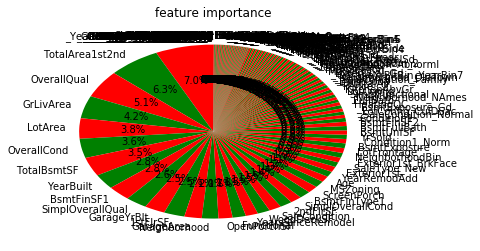

In [19]:
import matplotlib.pyplot as plt

% matplotlib inline
slices_hours = S
activities = l
colors = ['r', 'g']

plt.pie(slices_hours, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.title('feature importance')
plt.show()

Notre fonction revoit une liste des carateristiques et leurs score associé

## Définir une fonction pour ne garder dans la dataset que les variables qui expliquent à 95%  notre variable cible SalePrice.

In [252]:
def get_important_features(feature_importance):
    s,i=0,0    
    l=[]
    while s <= 0.9:
            s+=feature_importance[i][0]
            l.append(feature_importance[i][1])
            i+=1
            
    return l
get_important_features(feature_importance)



['TotalArea',
 'TotalArea1st2nd',
 'OverallQual',
 'GrLivArea',
 'LotArea',
 'OverallCond',
 'TotalBsmtSF',
 'YearBuilt',
 'BsmtFinSF1',
 'SimplOverallQual',
 'GarageYrBlt',
 '1stFlrSF',
 'GarageArea',
 'Neighborhood',
 'OpenPorchSF',
 'Functional',
 'YearsSinceRemodel',
 'WoodDeckSF',
 'SaleCondition',
 '2ndFlrSF',
 'SimplOverallCond',
 'BsmtFinType1',
 'ScreenPorch',
 'MSZoning',
 'Age',
 'YearRemodAdd',
 'Exterior1st',
 '_SaleType_New',
 '_Exterior1st_BrkFace',
 'NeighborhoodBin',
 'LotFrontage',
 'BsmtExposure',
 '_Condition1_Norm',
 'YrSold',
 'BsmtUnfSF',
 'BsmtFullBath',
 'BsmtFinSF2',
 'Condition1',
 '_SaleCondition_Normal',
 '_LotConfig_CulDSac',
 '_BsmtExposure_Gd',
 'HeatingQC',
 'FullBath',
 '_Neighborhood_NAmes',
 'SimplFunctional',
 'LotConfig',
 'KitchenAbvGr',
 'Fence',
 'CentralAir',
 'BsmtCond',
 '_SaleCondition_Family',
 '_Neighborhood_OldTown',
 '_GarageYrBltBin_YearBin7',
 '_ExterQual_Gd',
 'MoSold',
 'HighSeason',
 'GarageCars',
 'FireplaceQu',
 '_SaleCondition_Ab

## Il s'avère que la méthode de feature selection ne donne pas le meilleur RMSE 

In [253]:

train_df_munged=train_df_munged[get_important_features(feature_importance)]
test_df_munged=test_df_munged[get_important_features(feature_importance)]

In [254]:
len(test_df_munged)

1459

In [255]:
len(train_df_munged)

1456

## On a decidé de travailler avec le modèle extreme gradient boosting  , et afin de pouvoir réduire l'overfitting, il est necessaire d'optimiser nos hyperparamètres, n_estimators et le learning rate.

In [44]:

import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train_df_munged, label_df)
y_pred_x= regr.predict(train_df_munged)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred_x))

y_pred_xgb = regr.predict(test_df_munged)


('XGBoost score on training set: ', 0.0775006584943539)


### Afin de réduire l'overfitting il est important d'utiliser une régularisation l1. 
On a d'abord trouvé notre alpha pour tuner notre modèle lasso avec la cross validation en utillisant regr.alpha_ avec le LassoCV , on a trouvé le meilleure alpha = 0.00045979040927269187 

In [257]:

from sklearn.linear_model import Lasso , ElasticNet , RidgeCV ,LassoCV



alpha = 0.00045979040927269187
#regr = ElasticNet(alpha=best_alpha, max_iter=5000)
regr = Lasso(alpha=alpha, max_iter=50000)
#regr = LassoCV(cv=5 , random_state = 0)
# maintenant à l'aide de la fonction regr.alpha_  on trouve notre meilleure alpha
# print regr.alpha_ 
regr.fit(train_df_munged, label_df)
y_pred_l = regr.predict(train_df_munged)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred_l))

y_pred_lasso = regr.predict(test_df_munged)

y_pred = (y_pred_xgb + 2*y_pred_lasso) / 3

y_pred_reg=(y_pred_l+y_pred_x)/2

print("XGBoost and lasso score on training set: ", rmse(y_test, y_pred_reg))



('Lasso score on training set: ', 0.10719957787361478)
('XGBoost and lasso score on training set: ', 0.09166168987455008)


In [247]:
y_pred

array([11.69363719, 11.99178533, 12.1155978 , ..., 12.04485023,
       11.71367972, 12.27378401])

In [248]:

y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('submission_final.csv', header=True, index_label='Id')

 Cette méthode ci-dessus nous a donné le meilleure classement kaggle (classée 730 )

## Une autre approche PCA : Réduction des dimensions avec analyse des composantes principales

In [227]:
from sklearn.decomposition import PCA

pca = PCA(n_components=81)

principalComponents_train = pca.fit_transform(train_df_munged.values)
principalComponents_test = pca.fit_transform(test_df_munged.values)

print principalComponents_train.shape , principalComponents_test.shape

print pca.explained_variance_ratio_

(1456, 81) (1459, 81)
[0.17306682 0.05350351 0.04551891 0.04077671 0.03522671 0.03188554
 0.02637321 0.02559108 0.02147338 0.01973191 0.01901887 0.01823768
 0.01787471 0.01661857 0.01546179 0.01502202 0.01441686 0.01393313
 0.01332003 0.01323807 0.01288978 0.01203568 0.01181044 0.01140744
 0.01118718 0.01035713 0.01001575 0.0098776  0.0092907  0.00878535
 0.008439   0.00842775 0.00813179 0.00794484 0.00776447 0.00769484
 0.00697672 0.00689752 0.00650489 0.00635159 0.00591561 0.00582511
 0.00570146 0.00563057 0.005454   0.00536632 0.00498093 0.00480348
 0.00457275 0.00444541 0.00419026 0.00408842 0.00399742 0.00390671
 0.00384323 0.00363738 0.00354214 0.00348336 0.00345371 0.00330227
 0.00316736 0.00310801 0.00286455 0.00263689 0.00260906 0.00254589
 0.00251879 0.00241836 0.00226767 0.00223015 0.00217991 0.00205414
 0.00188234 0.00187696 0.00182646 0.00176497 0.00171506 0.00162185
 0.00146983 0.00144504 0.00140049]


In [228]:
principalDf_train = pd.DataFrame(data = principalComponents_train
             , columns = range(0,list(principalComponents_train.shape)[1]))

principalDf_test = pd.DataFrame(data = principalComponents_test
             , columns = range(0,list(principalComponents_test.shape)[1]))

principalDf_test

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,-3.571408,-4.217402,-0.096884,0.675288,1.154890,-1.069236,-1.558719,0.013168,1.020418,0.989119,...,-0.100967,-0.041574,-0.358336,-0.055175,0.017122,0.207910,-1.360838,0.256376,0.386902,-1.276110
1,-0.546354,-3.302050,1.253671,1.575666,-0.099595,0.249438,-3.340523,-0.210844,-0.295450,-2.227293,...,0.567625,0.068927,-0.248843,-0.436556,-0.593624,-0.197527,0.324773,1.004237,0.701508,0.540738
2,2.066261,0.577370,-0.162887,-1.464558,0.665334,1.597267,-2.619641,0.337510,1.969698,-2.007115,...,0.299870,-0.228285,0.455916,-0.414109,0.200768,0.584384,-0.590418,-0.135959,0.208522,-0.259273
3,3.284782,0.947140,0.266234,-1.325136,0.789180,1.760537,-2.463203,1.095370,0.293953,-1.888923,...,-0.462022,-0.036001,-0.151523,-0.825204,-1.161041,0.199083,-0.067001,0.082895,-0.282798,0.074648
4,3.438048,0.519988,-2.818554,1.726679,1.476928,0.509775,3.065841,1.324658,0.863452,0.465918,...,0.347889,-0.243664,-0.272938,0.949566,-0.488547,-0.122812,0.183812,0.024756,0.048587,0.609656
5,1.281433,1.812980,0.221018,-1.837143,1.428882,1.687435,-2.379585,-0.967266,1.941217,-1.342395,...,0.466007,-0.672567,0.398092,0.603282,0.190866,0.249073,-0.523221,-0.055809,0.346517,0.568942
6,0.902267,-2.399136,-2.115308,-0.693276,0.048562,-0.987465,-4.394200,3.219477,0.387779,-0.711773,...,0.196744,-0.056228,0.068110,0.738193,-0.668812,-0.840492,-0.123387,0.356062,-0.154348,0.514361
7,1.375868,2.242442,-0.115986,-1.692380,1.764808,1.192684,-2.148762,-1.095129,1.783972,-1.414356,...,-0.175176,0.138291,0.477080,-0.015531,-0.372221,0.753140,-0.456903,0.147711,0.193631,0.051897
8,1.696973,-2.271006,-1.362571,1.247566,0.241922,0.081514,-0.467880,0.647150,1.175437,-2.704801,...,0.116171,-0.420031,0.863038,-0.582007,-0.364829,-0.052150,-0.487183,-0.444047,0.464664,0.206419
9,-2.952468,-5.020262,-1.740046,1.246880,1.571659,0.155912,-1.810170,0.646016,1.707347,-1.224332,...,0.389472,0.160206,-0.719237,-0.064693,-0.045957,-0.291744,0.240711,0.373422,0.385224,-0.281284


In [229]:
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(principalDf_train, label_df)


y_pred_x= regr.predict(principalDf_train)
y_test = label_df
print("XGBoost score on training set: ", rmse(y_test, y_pred_x))


y_pred_xgb = regr.predict(principalDf_test)



('XGBoost score on training set: ', 0.0619922950867125)


In [224]:
from sklearn.linear_model import Lasso , ElasticNet , RidgeCV ,LassoCV

best_alpha = 0.00099
alpha = 0.0016142533257845059
#regr = ElasticNet(alpha=best_alpha, max_iter=5000)
regr = Lasso(alpha=alpha, max_iter=50000)
#regr = LassoCV(cv=5 , random_state = 0)
regr.fit(principalComponents_train, label_df)

y_pred_l = regr.predict(principalComponents_train)
y_test = label_df
print("Lasso score on training set: ", rmse(y_test, y_pred_l))

y_pred_lasso = regr.predict(principalComponents_test)

('Lasso score on training set: ', 0.10780966876123488)


In [231]:
y_pred = (y_pred_xgb + y_pred_lasso) / 2

y_pred_reg=(y_pred_l+y_pred_x)/2

print("XGBoost and lasso score on training set: ", rmse(y_test, y_pred_reg))

y_pred = np.exp(y_pred)

pred_df = pd.DataFrame(y_pred, index=test_df["Id"], columns=["SalePrice"])
pred_df.to_csv('submission_final_pca.csv', header=True, index_label='Id')

('XGBoost and lasso score on training set: ', 0.08235373752883779)


Il parait que la réduction des dimensions avec ACP ne donne pas un score intéressant au niveau des données test. 